In [1]:
import os
from dotenv import load_dotenv
from typing import Dict, List, Any, Optional, Annotated, Union, Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage, ToolMessage
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import MessagesState

from langgraph.prebuilt import tools_condition, ToolNode

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

from IPython.display import Image, display

In [2]:
load_dotenv()

True

In [3]:
db = SQLDatabase.from_uri("sqlite:///../sql-support-bot/chinook.db")
print(db.get_usable_table_names())

['albums', 'artists', 'customers', 'employees', 'genres', 'invoice_items', 'invoices', 'media_types', 'playlist_track', 'playlists', 'tracks']


In [4]:
os.environ["LANGCHAIN_PROJECT"] = "music-store-support-demo-prep"

## Set up state

In [5]:
class MusicStoreChatbotState(MessagesState):
    customer_id: Optional[int]
    current_mode: Literal["router", "account", "music"]

In [6]:
model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

## Helper Functions

In [7]:
def get_last_human_message(messages: List[BaseMessage]) -> Optional[HumanMessage]:
    """Extract the last human message from the conversation history."""
    for message in reversed(messages):
        if isinstance(message, HumanMessage):
            return message
    return None

## Graph definition

### Router Agent

In [8]:
# Router Agent
router_system_message = """You are a helpful customer support assistant for a music store.
Your job is to determine what the customer needs help with and route them to the appropriate department:

1. ACCOUNT - For updating personal information, account details, or authentication
2. MUSIC - For music recommendations, searching for songs/artists, or questions about music inventory
3. UNRELATED - for anything that does not fit into ACCOUNT or MUSIC

Respond with only the name of the department (ACCOUNT, MUSIC or UNRELATED) that best matches their query.
If they want to access personal information and have not provided a customer ID, please ask for the ID.
"""


def route_conversation(state: MusicStoreChatbotState) -> Literal["account", "music", "router"]:
    """Route the conversation to the appropriate department"""
    print("Routing conversation...")
    last_human_message = get_last_human_message(state["messages"])
    if not last_human_message:
        print("No human message found...")
        return state

    # Prepare conversation for the router
    router_messages = [SystemMessage(content=router_system_message), last_human_message]
    response = model.invoke(router_messages)
    print(f"Raw router response = {response.content}")

    # Update the state with the correct department
    content = response.content.lower()
    if "account" in content:
        department = "account"
    elif "music" in content:
        department = "music"
    else:
        department = "unrelated"

    # Return the routing decision
    return {"current_mode": department}


def out_of_scope_message_node(state: MusicStoreChatbotState):
    print("out_of_scope_message_node invoked")
    print("=" * 50)
    print("I can only help with music recommendations and account updates. Please try again")
    print("=" * 50)
    return state


In [9]:
def music_node(state: MusicStoreChatbotState):
    print("music_node invoked")
    return state


def account_node(state: MusicStoreChatbotState):
    print("account_node invoked")
    return state

def route_condition(state: MusicStoreChatbotState) -> str:
    """Return the routing condition based on the current state"""
    return state["current_mode"]

entry_builder = StateGraph(MusicStoreChatbotState)
entry_builder.add_node("route_conversation", route_conversation)
# For sub-graphs, use the sub-graph builder instead of the function name, 
# ex. entry_builder.add_node("music_node", qs_builder.compile())
entry_builder.add_node("music_node", music_node)
entry_builder.add_node("account_node", account_node)
entry_builder.add_node("out_of_scope_message_node", out_of_scope_message_node)

# Add the starting edge
entry_builder.add_edge(START, "route_conversation")

# Add conditional edges - this is the key part
entry_builder.add_conditional_edges(
    "route_conversation",  # Source node
    route_condition,  # Function that returns the condition value
    {
        "music": "music_node",
        "account": "account_node",
        "unrelated": "out_of_scope_message_node"
    }
)

# Add the ending edges
entry_builder.add_edge("music_node", END)
entry_builder.add_edge("account_node", END)
entry_builder.add_edge("out_of_scope_message_node", END)

memory = MemorySaver()
# Can hard-code interruptions  using `builder.compile(interrupt_before=["tools"], checkpointer=memory)`
graph = entry_builder.compile(checkpointer=memory)

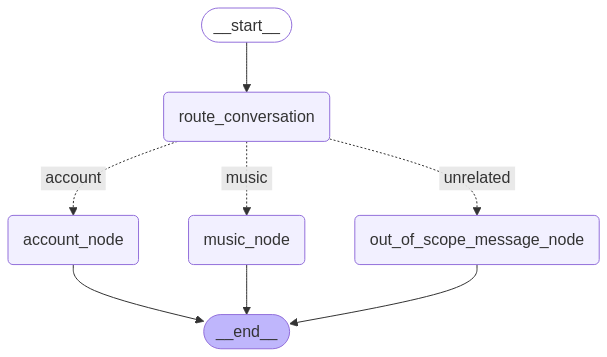

In [10]:
display(Image(graph.get_graph().draw_mermaid_png()))

### Test

In [11]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "1"}}

# Then use it in your invoke call
graph.invoke(
    {"messages": [HumanMessage(content="Hey. recommend music by Amy Winehouse")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

Routing conversation...
Raw router response = MUSIC
music_node invoked


{'messages': [HumanMessage(content='Hey. recommend music by Amy Winehouse', additional_kwargs={}, response_metadata={}, id='3ee27b40-0c80-4c53-b78b-2b6a874ba00b')],
 'customer_id': None,
 'current_mode': 'music'}

In [12]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "1"}}

# Then use it in your invoke call
graph.invoke(
    {"messages": [HumanMessage(content="Hey, my customer ID is 2. Please update my email to a@b.com")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

Routing conversation...
Raw router response = ACCOUNT
account_node invoked


{'messages': [HumanMessage(content='Hey. recommend music by Amy Winehouse', additional_kwargs={}, response_metadata={}, id='3ee27b40-0c80-4c53-b78b-2b6a874ba00b'),
  HumanMessage(content='Hey, my customer ID is 2. Please update my email to a@b.com', additional_kwargs={}, response_metadata={}, id='07ecd7bd-ee43-4592-8864-7d4dd1377c28')],
 'customer_id': None,
 'current_mode': 'account'}

In [13]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "1"}}

# Then use it in your invoke call
graph.invoke(
    {"messages": [HumanMessage(content="What is the meaning of life?")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

Routing conversation...
Raw router response = UNRELATED
out_of_scope_message_node invoked
I can only help with music recommendations and account updates. Please try again


{'messages': [HumanMessage(content='Hey. recommend music by Amy Winehouse', additional_kwargs={}, response_metadata={}, id='3ee27b40-0c80-4c53-b78b-2b6a874ba00b'),
  HumanMessage(content='Hey, my customer ID is 2. Please update my email to a@b.com', additional_kwargs={}, response_metadata={}, id='07ecd7bd-ee43-4592-8864-7d4dd1377c28'),
  HumanMessage(content='What is the meaning of life?', additional_kwargs={}, response_metadata={}, id='c6e795b0-f27c-4214-bf20-295039533f30')],
 'customer_id': None,
 'current_mode': 'unrelated'}

## Recommendation Agent

### Tool Helpers- Allow fuzzy retrieval for artists and tracks/songs

In [14]:
artists = db._execute("SELECT * FROM artists")
songs = db._execute("SELECT * FROM tracks")
artist_retriever = SKLearnVectorStore.from_texts(
    [a['Name'] for a in artists],
    OpenAIEmbeddings(),
    metadatas=artists
).as_retriever()


song_retriever = SKLearnVectorStore.from_texts(
    [a['Name'] for a in songs],
    OpenAIEmbeddings(),
    metadatas=songs
).as_retriever()

### LLM with Tools

In [15]:
@tool
def get_albums_by_artist(artist: str):
    """Get albums by an artist (or similar artists)."""
    print("T" * 50)
    print("get_albums_by_artist tool called")
    print("T" * 50)
    docs = artist_retriever.get_relevant_documents(artist)
    artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
    return db.run(
        f"SELECT Title, Name as ArtistName FROM albums LEFT JOIN artists ON albums.ArtistId = artists.ArtistId WHERE albums.ArtistId in ({artist_ids});",
        include_columns=True)


@tool
def get_tracks_by_artist(artist: str):
    """Get songs by an artist (or similar artists)."""
    print("T" * 50)
    print("get_tracks_by_artist tool called")
    print("T" * 50)
    docs = artist_retriever.get_relevant_documents(artist)
    artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
    return db.run(
        f"SELECT tracks.Name as SongName, artists.Name as ArtistName FROM albums LEFT JOIN artists ON albums.ArtistId = artists.ArtistId LEFT JOIN tracks ON tracks.AlbumId = albums.AlbumId WHERE albums.ArtistId in ({artist_ids});",
        include_columns=True)


@tool
def search_songs(song_title: str):
    """Search for songs by title."""
    print("T" * 50)
    print("search_songs tool called")
    print("T" * 50)
    docs = song_retriever.get_relevant_documents(song_title)
    return [{"Title": doc.page_content, "TrackId": doc.metadata["TrackId"]} for doc in docs[:5]]


@tool
def get_similar_music(genre: str, artist: str = ""):
    """Get music recommendations based on genre and optionally artist."""
    print("T" * 50)
    print("get_similar_music tool called")
    print("T" * 50)
    # Find genre ID
    genre_query = f"""
    SELECT GenreId FROM genres 
    WHERE Name LIKE '%{genre}%' 
    LIMIT 1
    """
    genre_result = db.run(genre_query)

    if not genre_result:
        return f"No genre found matching '{genre}'"

    genre_id = genre_result.split('|')[0].strip()

    # Get tracks in that genre, optionally filtering by artist
    artist_filter = ""
    if artist:
        docs = artist_retriever.get_relevant_documents(artist)
        if docs:
            artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
            artist_filter = f"AND albums.ArtistId IN ({artist_ids})"

    query = f"""
    SELECT tracks.Name as TrackName, artists.Name as ArtistName, albums.Title as AlbumTitle
    FROM tracks
    JOIN albums ON tracks.AlbumId = albums.AlbumId
    JOIN artists ON albums.ArtistId = artists.ArtistId
    WHERE tracks.GenreId = {genre_id} {artist_filter}
    ORDER BY RANDOM()
    LIMIT 5
    """

    return db.run(query, include_columns=True)

In [16]:
tools = [
    get_albums_by_artist,
    get_tracks_by_artist,
    search_songs,
    get_similar_music
]
music_recommendation_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
music_recommendation_model_with_tools = music_recommendation_model.bind_tools(tools)

## Graph Definition

In [17]:
# Music Recommendation Agent
music_system_message = """You are a music specialist at a music store.
You can help customers:
1. Find music by specific artists
2. Discover new songs similar to their interests
3. Search for specific tracks
4. Get recommendations based on genres

Always be conversational and enthusiastic about music. If you don't find exactly what they're looking for, suggest alternatives.
"""


def handle_music_query(state: MusicStoreChatbotState):
    """Handle music-related queries"""
    print("Processing music query...")
    
    # Build messages for the music agent
    messages = [SystemMessage(content=music_system_message)]
    # Add some conversation context
    context_messages = state["messages"][-5:] if len(state["messages"]) > 5 else state["messages"]
    messages.extend(context_messages)

    # Let the agent determine what to do next
    response = music_recommendation_model_with_tools.invoke(messages)
    print(f"Music agent: {response.content}")

    return {
        "messages": state["messages"] + [response]
    }

In [18]:
music_recommendation_graph_builder = StateGraph(MusicStoreChatbotState)

music_recommendation_graph_builder.add_node("handle_music_query", handle_music_query)
music_recommendation_graph_builder.add_node("tools", ToolNode(tools))

# Add the starting edge
music_recommendation_graph_builder.add_edge(START, "handle_music_query")
music_recommendation_graph_builder.add_conditional_edges(
    "handle_music_query",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
music_recommendation_graph_builder.add_edge("tools", "handle_music_query")
music_recommendation_graph_builder.add_edge("handle_music_query", END)

memory = MemorySaver()
# Can hard-code interruptions  using `builder.compile(interrupt_before=["tools"], checkpointer=memory)`
music_recommendation_graph = music_recommendation_graph_builder.compile(checkpointer=memory)

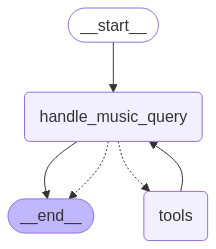

In [19]:
display(Image(music_recommendation_graph.get_graph().draw_mermaid_png()))

### Test

In [20]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "1"}}

# Then use it in your invoke call
music_recommendation_graph.invoke(
    {"messages": [HumanMessage(content="Hey, recommend music by Amy Winehouse")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

Processing music query...
Music agent: 
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
get_albums_by_artist tool called
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


/var/folders/h0/6_6mqq755ks82f6p8nvrzqlr0000gn/T/ipykernel_77816/1872880502.py:7: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = artist_retriever.get_relevant_documents(artist)


Processing music query...
Music agent: Amy Winehouse has some incredible albums that showcase her unique voice and style! Here are her notable works:

1. **Back to Black** - This is her iconic album featuring hits like "Rehab" and "You Know I'm No Good."
2. **Frank** - Her debut album, which includes beautiful tracks like "Stronger Than Me" and "You Sent Me Flying."

If you're looking for specific songs or more recommendations, just let me know! 🎶


{'messages': [HumanMessage(content='Hey, recommend music by Amy Winehouse', additional_kwargs={}, response_metadata={}, id='eca43832-0c7b-4045-add2-70c17e5a8745'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_H3A90FL1sDuXjqHlLYPyZ0wP', 'function': {'arguments': '{"artist":"Amy Winehouse"}', 'name': 'get_albums_by_artist'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 210, 'total_tokens': 230, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9aad257e-4507-4087-8e67-9fca877a3438-0', tool_calls=[{'name': 'get_albums_by_artist', 'args': {'artist': 'Amy Winehouse'}, 'id': 'call_H3A90FL1sDuXjqHlLYPyZ0wP', '

In [21]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "2"}}

# Then use it in your invoke call
response = music_recommendation_graph.invoke(
    {"messages": [HumanMessage(content="Hey, recommend songs by Green Day")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

Processing music query...
Music agent: 
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
get_tracks_by_artist tool called
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Processing music query...
Music agent: Here are some fantastic songs by Green Day that you might enjoy:

1. **Maria**
2. **Poprocks And Coke**
3. **Longview**
4. **Welcome To Paradise**
5. **Basket Case**
6. **When I Come Around**
7. **She**
8. **J.A.R. (Jason Andrew Relva)**
9. **Geek Stink Breath**
10. **Brain Stew**
11. **Jaded**
12. **Walking Contradiction**
13. **Stuck With Me**
14. **Hitchin' A Ride**
15. **Good Riddance (Time Of Your Life)**
16. **Redundant**
17. **Nice Guys Finish Last**
18. **Minority**
19. **Warning**
20. **Waiting**
21. **Macy's Day Parade**
22. **American Idiot**
23. **Holiday**
24. **Boulevard Of Broken Dreams**
25. **Wake Me Up When September Ends**

And many more! If you have a specific vibe or theme in mind, let me know, and I can suggest more tailored recommendations! 🎶


In [22]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "3"}}

# Then use it in your invoke call
response = music_recommendation_graph.invoke(
    {"messages": [HumanMessage(content="Hey, is Boulevard Of Broken Dreams available for purchase?")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

Processing music query...
Music agent: 
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
search_songs tool called
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Processing music query...
Music agent: Yes! "Boulevard Of Broken Dreams" is available. Would you like to know more about it, or perhaps explore some similar songs?


In [23]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "4"}}

# Then use it in your invoke call
response = music_recommendation_graph.invoke(
    {"messages": [HumanMessage(content="Hey, I like Boulevard Of Broken Dreams. What other albums and songs would you recommend?")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

Processing music query...
Music agent: 
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
get_tracks_by_artist tool called
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
get_albums_by_artist tool called
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
get_similar_music tool called
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Processing music query...
Music agent: Awesome choice with "Boulevard Of Broken Dreams"! It's such a powerful song. Here are some great recommendations for you:

### Songs by Green Day:
1. **"Basket Case"**
2. **"Wake Me Up When September Ends"**
3. **"American Idiot"**
4. **"Good Riddance (Time Of Your Life)"**
5. **"Brain Stew"**
6. **"Holiday"**
7. **"Longview"**
8. **"She"**
9. **"J.A.R. (Jason Andrew Relva)"**
10. **"St. Jimmy"**

### Albums by Green Day:
1. **"American Idiot"**
2. **"International Superhits"**
3. **"Dookie"**
4. **"Nimrod"**
5. *

## Account Agent

### Tools

In [24]:
customer_account_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

In [25]:
@tool
def get_customer_info(customer_id: int):
    """Look up customer info given their ID. Requires customer authentication."""
    return db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")

@tool
def update_customer_info(customer_id: int, field: str, value: str):
    """
    Update a customer's information. This is a sensitive operation that requires human approval.
    - customer_id: The ID of the customer to update
    - field: The field to update (FirstName, LastName, Company, Address, City, State, Country, PostalCode, Phone, Email)
    - value: The new value for the field
    """
    allowed_fields = ["FirstName", "LastName", "Company", "Address", "City", 
                       "State", "Country", "PostalCode", "Phone", "Email"]

    if field not in allowed_fields:
        return f"Error: Cannot update field '{field}'. Allowed fields are: {', '.join(allowed_fields)}"

    # Verify customer exists first
    customer = db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")
    if not customer:
        return f"Error: No customer found with ID {customer_id}"

    # This is what would actually run after approval
    return f"Successfully updated {field} to '{value}' for customer {customer_id}"


customer_id_extractor_message = """You are a customer account security specialist.
You process customer queries to extract the numeric customer ID from them.
For example, if a query says "My customer ID is 42", the Customer ID is 42.
If the query does not provide the customer ID, return UNAVAILABLE.
Return only the customer ID or UNAVAILABLE, as appropriate.
"""

def extract_customer_id(message: HumanMessage) -> Optional[int]:
    """Returns the Customer ID if it is available in the user query."""
    print("T" * 50)
    print(f"extract_customer_id called with {message}")
    print("T" * 50)
    response = customer_account_model.invoke(message)
    print(f"Derived ID = {response}")
    if response.isdigit():
        return {"customer_id": int(response)}
    else:
        return None

In [26]:
customer_account_tools = [
    get_customer_info,
    update_customer_info
]
customer_account_model_with_tools = model.bind_tools(customer_account_tools)

### Graph Definition

In [32]:
######################################################

def route_user_account_query(state: MusicStoreChatbotState) -> Optional[int]:
    """Route the account to the processor. If the ID is not found or is invalid, it is sent to 
    the out of scope message node."""
    print("Routing for user account...")
    last_human_message = get_last_human_message(state["messages"])
    if not last_human_message:
        print("No human message found...")
        return {"customer_id": None}

    if not state["customer_id"]:
        print("Customer ID not found")
        return {"customer_id": None}
    else:
        print(f"Customer ID found {state["customer_id"]}")
        return {"customer_id": state["customer_id"]}

    # Return the routing decision
    return {"current_mode": department}


def out_of_scope_message_node(state: MusicStoreChatbotState):
    print("out_of_scope_message_node invoked")
    print("=" * 50)
    print("I can only help with music recommendations and account updates. Please try again")
    print("=" * 50)
    return state




def route_condition(state: MusicStoreChatbotState) -> str:
    """Return the routing condition based on the current state"""
    return state["current_mode"]

entry_builder = StateGraph(MusicStoreChatbotState)
entry_builder.add_node("route_conversation", route_conversation)
# For sub-graphs, use the sub-graph builder instead of the function name, 
# ex. entry_builder.add_node("music_node", qs_builder.compile())
entry_builder.add_node("music_node", music_node)
entry_builder.add_node("account_node", account_node)
entry_builder.add_node("out_of_scope_message_node", out_of_scope_message_node)

# Add the starting edge
entry_builder.add_edge(START, "route_conversation")

# Add conditional edges - this is the key part
entry_builder.add_conditional_edges(
    "route_conversation",  # Source node
    route_condition,  # Function that returns the condition value
    {
        "music": "music_node",
        "account": "account_node",
        "unrelated": "out_of_scope_message_node"
    }
)

######################################################

    


def screen_for_customer_id(state: MusicStoreChatbotState):
    messages: List[BaseMessage] = state["messages"]
    last_human_message = get_last_human_message(messages)
    if not last_human_message:
        print("No human messages available")
        return state
    else:
        print(last_human_message)
        extracted_id = extract_customer_id(last_human_message)
        if extracted_id:
            print(f"Found customer ID {extracted_id}")
            print(state)
            return {"customer_id": extracted_id}
        else:
            return state


account_system_message = """You are a customer account specialist at a music store.
You can help customers:
1. Retrieve their account information
2. Update their profile details

IMPORTANT: 
- Always verify you have the customer_id before taking any actions.
- For security, any updates to customer information require human manager approval.
- DO NOT make updates without explicit approval.
"""

def handle_account_query(state: MusicStoreChatbotState):
    """Handle account-related queries"""
    # Check if we have customer ID
    if not state.get("customer_id"):
        # We need a customer ID to proceed
        return {
            "messages": state["messages"] + [
                AIMessage(content="I'll be happy to help with your account. Could you please provide your customer ID so I can access your information?")
            ]
        }

    # Build messages for the account agent
    messages = [SystemMessage(content=account_system_message)]
    # Add some conversation context
    context_messages = state["messages"][-5:] if len(state["messages"]) > 5 else state["messages"]
    messages.extend(context_messages)

    # Add customer context
    customer_id = state["customer_id"]
    messages.append(SystemMessage(content=f"Current authenticated customer ID: {customer_id}"))

    # Let the agent determine what to do next
    response = model.bind_tools(tools=[get_customer_info, update_customer_info]).invoke(messages)

    # Return the response - if this contains a tool call to update_customer_info,
    # the graph will break at the next step for human approval
    return {
        "messages": state["messages"] + [response]
    }

In [33]:
customer_account_graph_builder = StateGraph(MusicStoreChatbotState)

customer_account_graph_builder.add_node("screen_for_customer_id", screen_for_customer_id)
customer_account_graph_builder.add_node("handle_account_query", handle_account_query)
customer_account_graph_builder.add_node("tools", ToolNode(customer_account_tools))

# Add the starting edge
screen_for_customer_id
customer_account_graph_builder.add_edge(START, "screen_for_customer_id")
customer_account_graph_builder.add_edge("screen_for_customer_id", "handle_account_query")
customer_account_graph_builder.add_conditional_edges(
    "handle_account_query",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
customer_account_graph_builder.add_edge("tools", "handle_account_query")
customer_account_graph_builder.add_edge("handle_account_query", END)

customer_account_memory = MemorySaver()
# Can hard-code interruptions  using `builder.compile(interrupt_before=["tools"], checkpointer=memory)`
customer_account_graph = customer_account_graph_builder.compile(checkpointer=customer_account_memory)

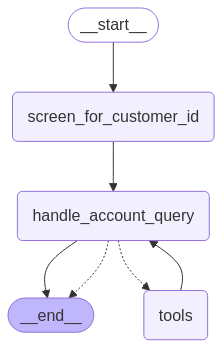

In [34]:
display(Image(customer_account_graph.get_graph().draw_mermaid_png()))

### Tests

In [35]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "21"}}

# Then use it in your invoke call
customer_account_graph.invoke(
    {"messages": [HumanMessage(content="Hey, recommend music by Amy Winehouse")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

content='Hey, recommend music by Amy Winehouse' additional_kwargs={} response_metadata={} id='b1a250f5-7105-4d6c-998a-f734b84ac9d1'
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
extract_customer_id called with content='Hey, recommend music by Amy Winehouse' additional_kwargs={} response_metadata={} id='b1a250f5-7105-4d6c-998a-f734b84ac9d1'
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


ValueError: Invalid input type <class 'langchain_core.messages.human.HumanMessage'>. Must be a PromptValue, str, or list of BaseMessages.

In [ ]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "22"}}

# Then use it in your invoke call
customer_account_graph.invoke(
    {"messages": [HumanMessage(content="Hey, my customer ID is 2. Please update my email to a@b.com")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

In [ ]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "23"}}

# Then use it in your invoke call
customer_account_graph.invoke(
    {"messages": [HumanMessage(content="What is the meaning of life?")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

## Compound Agent

In [ ]:
def music_node(state: MusicStoreChatbotState):
    print("music_node invoked")
    return state


def account_node(state: MusicStoreChatbotState):
    print("account_node invoked")
    return state

def route_condition(state: MusicStoreChatbotState) -> str:
    """Return the routing condition based on the current state"""
    return state["current_mode"]

front_desk_graph_builder = StateGraph(MusicStoreChatbotState)
front_desk_graph_builder.add_node("route_conversation", route_conversation)
front_desk_graph_builder.add_node("music_node", music_recommendation_graph_builder.compile())
# front_desk_graph_builder.add_node("account_node", account_node)
front_desk_graph_builder.add_node("account_node", customer_account_graph_builder.compile())
front_desk_graph_builder.add_node("out_of_scope_message_node", out_of_scope_message_node)

# Add the starting edge
front_desk_graph_builder.add_edge(START, "route_conversation")

# Add conditional edges - this is the key part
front_desk_graph_builder.add_conditional_edges(
    "route_conversation",  # Source node
    route_condition,  # Function that returns the condition value
    {
        "music": "music_node",
        "account": "account_node",
        "unrelated": "out_of_scope_message_node"
    }
)

# Add the ending edges
front_desk_graph_builder.add_edge("music_node", END)
front_desk_graph_builder.add_edge("account_node", END)
front_desk_graph_builder.add_edge("out_of_scope_message_node", END)

memory = MemorySaver()
# Can hard-code interruptions  using `builder.compile(interrupt_before=["tools"], checkpointer=memory)`
front_desk_graph = front_desk_graph_builder.compile(checkpointer=memory)

In [ ]:
display(Image(front_desk_graph.get_graph(xray=True).draw_mermaid_png()))

### Test

In [ ]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "31"}}

# Then use it in your invoke call
front_desk_graph.invoke(
    {"messages": [HumanMessage(content="Hey. recommend music by Amy Winehouse")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

In [ ]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "32"}}

# Then use it in your invoke call
front_desk_graph.invoke(
    {"messages": [HumanMessage(content="Hey, my customer ID is 2. Please update my email to a@b.com")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

In [ ]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "33"}}

# Then use it in your invoke call
front_desk_graph.invoke(
    {"messages": [HumanMessage(content="What is the meaning of life?")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)